In [6]:
# 导入模块
%matplotlib inline
import torch
import numpy as np
import pylab as pl
from torch import nn

torch.manual_seed(1)
np.random.seed(1)

In [7]:
# 定义一个由单层线性层构成的的简单RNN单元
class ERNN_Cell(nn.Module):
    def __init__(self, input_size, hidden_size, activation=None):
        super(ERNN_Cell,self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.activation = activation
        self.input_x = nn.Linear(self.input_size, self.hidden_size)
        self.input_h = nn.Linear(self.hidden_size, self.hidden_size)
        
    def forward(self, x, h):
        x = self.input_x(x)
        h = self.input_h(h)
        if activation is not None:
            return activation(x+h)
        else:
            return x + h

# 定义一个单层的简单RNN
class ERNN(nn.Module):
    def __init__(self, input_size, hidden_size, activation = None):
        super(ERNN,self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.activation = activation
        self.ernn = ERNN_Cell(self.input_size, self.hidden_size, activation=self.activation)
    def init_h(self, h_t):
        if h_t is not None:
            self.h_t = h_t
        else:
            self.h_t = torch.zeros(1,1,self.hidden_size)
    def forward(self, x, h_t=None):
        self.seq_length, self.batch_size, self.input_size = x.size()
        ys = []
        self.init_h(h_t)
        for t in range(0, self.seq_length):
            self.h_t = self.ernn(x[t], self.h_t)
            ys.append(self.h_t.view(1,1,-1))
        self.ys = torch.cat(ys)
        return self.ys, self.h_t

In [9]:
# 训练一个基于ERNN神经网络来作诗

## 读入用GloVe处理得到的文字 embeddings，以及句子数据。
import codecs

with codecs.open('data/word_embeddings_128.txt', mode='r', encoding='utf-8') as f:
    lines = f.readlines()

n_words = len(lines)
word_emb_dim = input_size = 128
word_embeddings = torch.nn.Embedding(n_words, word_emb_dim)
i2w = {}
w2i = {}
for i in range(n_words):
    line = lines[i].split(' ')
    i2w[i] = line[0]
    w2i[line[0]] = i
#    word_embeddings.weight[i] = torch.from_numpy(np.array(line[1:],dtype=np.float32))

word_embeddings.weight.require_grad = False

poems = []
max_line_length = 32
with codecs.open('data/poems.txt', mode='r', encoding='utf-8') as f:
    for poem in f:
        poem = poem.replace(' ','')
        if ':' in poem: poem = poem.split(':')[-1]
        poem = poem.replace('\n','')
        poem = poem.replace('\r','')
        if len(poem) < 24 or len(poem) > max_line_length or '(' in poem or u'（' in poem or u'）' in poem or ')' in poem:
            continue
        poem = 'S' + poem + 'E'
        poems.append(map(w2i.get, poem))

n_poems = len(poems)

print( 'Data summary:\n\n number of poems: {}\n number of words: {}\n'.format(n_poems, n_words))
print('Poem examples:\n\n'+'\n'.join([''.join(map(i2w.get, x)) for x in poems[:10]]))

Data summary:

 number of poems: 9749
 number of words: 7650

Poem examples:

S四时运灰琯，一夕变冬春。送寒余雪尽，迎岁早梅新。E
S上弦明月半，激箭流星远。落雁带书惊，啼猿映枝转。E
S初秋玉露清，早雁出空鸣。隔云时乱影，因风乍含声。E
S岸曲丝阴聚，波移带影疏。还将眉里翠，来就镜中舒。E
S贞条障曲砌，翠叶贯寒霜。拂牖分龙影，临池待凤翔。E
S散影玉阶柳，含翠隐鸣蝉。微形藏叶里，乱响出风前。E
S盘根直盈渚，交干横倚天。舒华光四海，卷叶荫三川。E
S近谷交萦蕊，遥峰对出莲。径细无全磴，松小未含烟。E
S疾风知劲草，板荡识诚臣。勇夫安识义，智者必怀仁。E
S太液仙舟迥，西园隐上才。未晓征车度，鸡鸣关早开。E


In [10]:
# 定义一个函数，随机返回一个 mini batch，用于训练，由于每一首诗歌的长度不同，我们此处规定每个batch只有一首诗。这样，就可以生成长度可变的诗歌。
def get_batch(batch_size=1):
    batch_raw = [poems[i][:] for i in np.random.randint(0, n_poems, batch_size)]
    max_length = max(map(len, batch_raw))
    for i in range(len(batch_raw)):
        for j in range(len(batch_raw[i]),max_length):
            batch_raw[i].append(0)
    batch_raw = torch.LongTensor(batch_raw).detach().unsqueeze(2).transpose(0,1)
    x = batch_raw[:-1].type(torch.float32)
    y = batch_raw[1:]
    return x, y

def idx2emb(x):
    return word_embeddings(x.type(torch.long)).squeeze(2).detach()
    

# 定义一个函数，输入一个 batch 返回句子
def batch2sent(batch):
    S = []
    batch = batch.type(torch.int32).detach()
    seq_length, batch_size, emb_size = batch.size()
    for i in range(batch_size):
        S.append(''.join(map(i2w.get, batch[:,i,:].view(-1).tolist())))
    return u'\n'.join(S)

x, y = get_batch(1)
print(batch2sent(x))
print(batch2sent(y))

# 定义一个生成器
class Generator(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, activation=None):
        super(Generator, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.activation = activation
        self.rnn = ERNN(self.input_size, self.hidden_size)
        self.output = nn.Linear(self.hidden_size,self.output_size)
        self.softmax = torch.nn.LogSoftmax(dim=-1)
    def init_h(self):
        return torch.randn(1, self.batch_size, self.hidden_size)
    def forward(self, x, h0=None):
        self.seq_length, self.batch_size, self.input_size = x.size()
        if h0 is None:
            h0 = self.init_h()
        y, ht = self.rnn(x,h0)
        y = y.view(-1,self.hidden_size)
        y = self.output(y)
        y = y.view(self.seq_length,self.batch_size,self.output_size)
        y = self.softmax(y)
        return y, ht

def poem_gen(model, w=None, cr=1e-1):
    with torch.no_grad():
        if not w in w2i or w is None:
            idx = np.random.randint(1,n_words)
            w = i2w[idx]
        else:
            idx = w2i[w]
        ht = None
        x0 = torch.FloatTensor([w2i['S']]).view(1,1,-1).detach()
        x0 = idx2emb(x0)
        y, ht = model(x0, ht)
        x = torch.LongTensor([w2i[w]]).view(1,1,-1).detach()
        x = idx2emb(x)
        s = []
        s.append(w)
        for t in range(max_line_length):
            y, ht = model(x, ht)
            not_done = True
            cnt = 0
            while not_done and cnt <50:
                k = min([1+np.random.binomial(3,0.5), y.size(-1)-1])
                x = torch.topk(y, k, dim=-1)[1].detach()
                x = x[:,:,min([np.random.geometric(0.3), k-1])].unsqueeze(2)
#                x = torch.argmax(y,dim=-1,keepdim=True)
                cnt += 1
                w = batch2sent(x)
                not_done = False
            if w == 'E':
                break
            s.append(w)
            x = idx2emb(x)
        return u''.join(s)
    
    
# 训练一个简单的 RNN 模型以生成诗歌

input_size = word_emb_dim
hidden_size = 128
output_size = n_words
activation = torch.relu

model = Generator(input_size, output_size, hidden_size, activation=activation)


S昨夜遥欢出建章，今朝缀赏度昭阳。传声莫闭黄金屋，为报先开白玉堂。
昨夜遥欢出建章，今朝缀赏度昭阳。传声莫闭黄金屋，为报先开白玉堂。E


Epoch0, Loss8.93999195099
Pred:
矿礨羜铺柔贝黻镆盂斡贝缎柔洮跕缎颃缎4亢竿阜ǖ箑蘗叨箑娙影蹬笆躅颃
Obs:
昨夜遥欢出建章，今朝缀赏度昭阳。传声莫闭黄金屋，为报先开白玉堂。E
Rnd:
蔻蕟闾嬴蹬婴缀跕申笥灀胥鸿漏盂串胥答宾输输缎镟豺矫影琏鹫疼腰瘁丐钢

Epoch50, Loss6.76181077957
Pred:
。。。。。。。。。。。。。。，。E。。，。。。，。。。。。。。。E
Obs:
忆昔同游紫阁云，别来三十二回春。白头相见双林下，犹是清朝未退人。E
Rnd:
始，，，人春。

Epoch100, Loss6.78451967239
Pred:
。，，，，。，，，。，。。，。。E，，。，，，。，，，，，，。，E
Obs:
失却青丝素发生，合欢罗带意全轻。古今人事皆如此，不独文君与马卿。E
Rnd:
愁，，。

Epoch150, Loss6.37457227707
Pred:
，。。，，。，，。，，。。，，。E。，。。，。，。。。。。，。，E
Obs:
烟霄微月澹长空，银汉秋期万古同。几许欢情与离恨，年年并在此宵中。E
Rnd:
死。

Epoch200, Loss6.53868484497
Pred:
，。。。，，不。，。，，E。。。。，不。。，，。E
Obs:
苏武节旌尽，李陵音信稀。花当陇上发，人向陇头归。E
Rnd:
蟏不不，，。不，一不不不，，，，，一。，一。不，，一。，。人，。不

Epoch250, Loss6.99988603592
Pred:
。，，，。。不。，。，，E，。，。。不。。。。，E
Obs:
吹沙复喷石，曲折仍圆旋。野客漱流时，杯粘落花片。E
Rnd:
摩。人，一。不，一。

Epoch300, Loss6.76303052902
Pred:
，，，。，。。，不，，，，，，，E，。，。，，。，，。。，，。，E
Obs:
莲华峰下锁雕梁，此去瑶池地共长。好为麻姑到东海，劝栽黄竹莫栽桑。E
Rnd:
甔，一。人不。不知不人，不。今。不人，一人。不人，一人不，一不。

Epoch350, Loss6.5670671463
Pred:
，，。。，。不，，，。。E。。。，。不。。。。。E
Obs:
远山谁放烧，疑是坛边醮。仙人错下山，拍手坛边笑。E
Rnd:
堄。不人，一。不知，人间。今日。今。不。不

Epoch3000, Loss6.56477975845
Pred:
不是不不，，，，不人不，。，，，E年不知。，，，不风不不。，，，E
Obs:
南邻酒熟爱相招，蘸甲倾来绿满瓢。一醉不知三日事，任他童稚作渔樵。E
Rnd:
峙时一夜，无限不得。不见人不知。

Epoch3050, Loss5.87008810043
Pred:
不得花十。。，。不是不知人，。，E人风。，。。，不知不不。，，，E
Obs:
共覆三衣中夜寒，披时不镇尼师坛。无因盖得龙宫地，畦里尘飞叶相残。E
Rnd:
膈夜一山，何人不见。

Epoch3100, Loss5.68059301376
Pred:
一日不不，。，，不人不风，。。，E人不山，。。，不日不山。，，。E
Obs:
越巂城南无汉地，伤心从此便为蛮。冤声一恸悲风起，云暗青天日下山。E
Rnd:
课日无限。一声一人。不是不见人，不见人。今来人不见。

Epoch3150, Loss5.40528726578
Pred:
不风不风风，，，不十花花人，。。E时不不，。。，不有不何日，。，E
Obs:
帝舜南巡去不还，二妃幽怨水云间。当时珠泪垂多少，直到如今竹尚斑。E
Rnd:
瘢山一人间，一夜一夜不。一年一声不见君，

Epoch3200, Loss5.25870609283
Pred:
不一人年。，，，不风不不，，，。E人不风不不人，不上不人。，，。E
Obs:
雨过前山日未斜，清蝉嘒嘒落槐花。车轮南北已无限，江上故人才到家。E
Rnd:
桯人不得人，何人间人间，不见何事。不见不见。一夜无限人间，何事不知

Epoch3250, Loss5.26517677307
Pred:
不，花。风，不来间，，。E人不人，，不人，。。。E
Obs:
去马嘶春草，归人立夕阳。元知数日别，要使两情伤。E
Rnd:
殚不见君，无事不是。今朝无限不知，一夜一年少，一夜，无事不见人间，

Epoch3300, Loss6.0716547966
Pred:
不不人，，，。。不知不人，知，。E风不不花，。，不山一风不里，，E
Obs:
身著袈裟手杖藤，水边行止不妨僧。禽栖日落犹孤立，隔浪秋山千万层。E
Rnd:
竟年年山下。不见何事。

Epoch3350, Loss5.20667934418
Pred:
一云不人落，，。不来不不，，。。E知不山不上，，不人不勤

Epoch6000, Loss5.71171808243
Pred:
一有不上不，不得何，，。E人不上，，不是不，，。E
Obs:
只爱满我腹，争如满害身。到头须扑破，却散与他人。E
Rnd:
秤人间花开。今夜无事，何人间，何处不见人。一年一枝，何处花。不见无

Epoch6050, Loss5.02383947372
Pred:
一里不花不，。。不君不花，，。。E上风知，。。，不日不山山，，，E
Obs:
万里辞家事鼓鼙，金陵驿路楚云西。江春不肯留归客，草色青青送马蹄。E
Rnd:
咙向山下春。今朝一夜不知人，何如一声无，何处无心，一片无限不，不是

Epoch6100, Loss4.8126707077
Pred:
一吹不不，，不是，里。，E逢不不见，不明不。，。E
Obs:
风鸣云外钟，鹤宿千年松。相思杳不见，月出山重重。E
Rnd:
穿人间上人间，不得不见，不得不知。不是不见不得。不知一片不见。

Epoch6150, Loss5.91490936279
Pred:
一风不不，，，。不来不舟不，知，E处不不，，。。不得不水不，。。E
Obs:
由来秉节世无双，独守孤城死不降。何似知机早回首，免教流血满长江。E
Rnd:
炬人何人间上。不得一枝花枝时。不知无端，一枝不见。不得一枝不得人。

Epoch6200, Loss5.39498758316
Pred:
一日不风不，，。不日不不不，。。E山不，不安，，不来不人，，，。E
Obs:
昨夜清凉梦本山，眠云唤鹤有惭颜。青莲道士长堪羡，身外无名至老闲。E
Rnd:
璐是一枝不知，一夜一夜，何人间，一片，一夜深山下。不得一枝花。不见

Epoch6250, Loss5.32397222519
Pred:
一来日声，知，。不人不上风，，。E人不道不，，，不云不来，，。。E
Obs:
从今一去不须低，见说辽东好去栖。努力莫辞仙路远，白云飞处免群鸡。E
Rnd:
俚君无心，一夜，一声一枝。不知无端人。不得无事不得。今来一夜无，一

Epoch6300, Loss4.56525945663
Pred:
一昏不不，，。。不十年年不，，。E日不中不。。，不人不知，，。。E
Obs:
黄昏鼓角似边州，三十年前上此楼。今日山城对垂泪，伤心不独为悲秋。E
Rnd:
鹜山不知无，一夜，一夜深。不见春来，一枝。今朝一夜深。今朝不见人。


Epoch8900, Loss5.60304307938
Pred:
一山风不不，，。不年不人不，，。E日今花无，，，不人不庭，，，，E
Obs:
身随猿鸟在深山，早有诗名到世间。客至上方留盥漱，龙泓洞水昼潺潺。E
Rnd:
憧风雨中不见，何事无事不见。

Epoch8950, Loss5.52419471741
Pred:
一道不云，，。，不年不水不，，。E知一，，，，，不人不自，，。。E
Obs:
莫言白雪少人听，高调都难称俗情。不是楚词询宋玉，巴歌犹掩绕梁声。E
Rnd:
日日无事不得。

Epoch9000, Loss5.65134096146
Pred:
一南不水不，，。不年不是不，。，E人不是不间，，一有不山，，，。E
Obs:
江上烟消汉水清，王师大破绿林兵。干戈用尽人成血，韩信空传壮士名。E
Rnd:
恩人不见人，不得，一片无事人，何人何人不得归，不得一夜，不是何事。

Epoch9050, Loss5.80667877197
Pred:
一知不来中，。。不人不逢不，。。E知不人不，，，不是不来不，，。E
Obs:
黯黯严城罢鼓鼙，数声相续出寒栖。不嫌惊破纱窗梦，却恐为妖半夜啼。E
Rnd:
冯朝无事无事。今朝一夜，一声无事。不见一夜不知，一年无心，一夜无人

Epoch9100, Loss5.17788887024
Pred:
一年不处，知，。一人不风，，。。E有不声不，。，不明不吹山，，。E
Obs:
高卧深居不见人，功名斗薮似灰尘。唯留一部清商乐，月下风前伴老身。E
Rnd:
郅马花发无事。今年一夜不见人间。不得春草无人，一夜无限春风吹时，今

Epoch9150, Loss5.00595426559
Pred:
不夜不上下，，。不山日不上，十。E年不，不，。，不道不风吹，，。E
Obs:
昨日雪山记尔名，吾今坐石已三生。少年道性易流动，莫遣秋风入别情。E
Rnd:
鹢日无限不得人，一年无事无限，一夜无人间，何人不得人，何事无事无事

Epoch9200, Loss6.23964929581
Pred:
一日不山不，，。不年不人，，。。E日不知一人，，不知不人，，。。E
Obs:
晋鄙兵回为重难，秦师收旆亦西还。今来不是无朱亥，谁降轩车问抱关。E
Rnd:
飔花春水，一夜深处。今朝一声不得人，何事一枝不得。今朝不得无。今年

Epoch9250

Epoch11800, Loss5.60738754272
Pred:
一风不月风，不上不，，。E知不不何，不风人花。。E
Obs:
石色凝秋藓，峰形若夏云。谁留秦苑地，好赠杏溪君。E
Rnd:
铤风吹不得归，不得不得不得人，一年一夜不见人，不得无限，一夜不知人

Epoch11850, Loss4.93527078629
Pred:
一十不，，，，。不里不人不，，。E人不人不，，，不知不军不，。。E
Obs:
三条陌上拂金羁，万里桥边映酒旗。此日令人肠欲断，不堪将入笛中吹。E
Rnd:
榷人间山中，一夜不得归，一夜无限无，一夜无心，一声一夜不。不得无事

Epoch11900, Loss5.93776130676
Pred:
一人不间，，。，不知不人人，，，E来不花人归，，不风不水，，。。E
Obs:
每逢人静慵多歇，不计程行困即眠。上得篮舆未能去，春风敷水店门前。E
Rnd:
缟风雨中不见，今日无限，何人间。不知不是一枝，一夜一夜，一枝花。今

Epoch11950, Loss5.41003990173
Pred:
一人不来不，不日不，声，E今如，，，不山，，。。E
Obs:
峄阳桐半死，延津剑一沈。如何宿昔内，空负百年心。E
Rnd:
瓒中无事不得归，何事无事不得。一夜一夜深，一夜深，一枝不得人，莫言

Epoch12000, Loss5.24979496002
Pred:
一人不上不，，，不风不上，，，。E有不上不，，，不人不，不知，。E
Obs:
云淡山横日欲斜，邮亭下马对残花。自从身逐征西府，每到开时不在家。E
Rnd:
翘花不得不见君，何事一枝不见。一声不得，一枝花。不得不见人。不知不

Epoch12050, Loss5.37716054916
Pred:
一日不上不，。。不人不风不，，。E有不，山，知，不人不不不，。。E
Obs:
今朝造化使春风，开折西施面上红。竟日眼前犹不足，数株舁入寸心中。E
Rnd:
附知何事一枝。不得不得无限春风。不是一枝无事人，今日无限，一夜，无

Epoch12100, Loss6.513422966
Pred:
一云不是不，不人不，，。E君不有不，不知不，，，E
Obs:
白马紫连钱，嘶鸣丹阙前。闻珂自蹀躞，不要下金鞭。E
Rnd:
棋年年少年年年年年。今朝何事一枝，今朝何事，何曾人间归，一夜一枝花

Epoch12

Epoch14650, Loss4.51795721054
Pred:
一花落人不，，，不年年风吹，，。E知不是前，，，不中不夜不，。。E
Obs:
看花无语泪如倾，多少春风怨别情。不识玉门关外路，梦中昨夜到边城。E
Rnd:
麳山花开一片来时，今朝无心一夜归，一片无限春。不得春来人，一夜无限

Epoch14700, Loss5.6574754715
Pred:
风日吹，，，不来不人山。E山不风南，不年不夜，，E
Obs:
含风摇砚水，带雨拂墙衣。乍似秋江上，渔家半掩扉。E
Rnd:
踍年来往不得。

Epoch14750, Loss6.18409919739
Pred:
一来不逢不间。，不来不人中，。。E日不，中，。，不上不来不，，。E
Obs:
偶然相遇人间世，合在增城阿姥家。有此倾城好颜色，天教晚发赛诸花。E
Rnd:
困日暮风雨中，何事无心在夜。今朝无限春。不是无限不得，一片一夜深，

Epoch14800, Loss4.67228412628
Pred:
一此不有无，。，不处不上不，，。E有不水，，，，不人不人人声，。E
Obs:
从来只有情难尽，何事名为情尽桥。自此改名为折柳，任他离恨一条条。E
Rnd:
暠得无心不知，何如何人来人间人，不得无心一夜，春来一夜深，不知何事

Epoch14850, Loss6.75332212448
Pred:
一人不不不，不是不。，。E来不夜不，不人一，，，E
Obs:
古人非傲吏，自阙经世务。偶寄一微官，婆娑数株树。E
Rnd:
蓍是一片无心不知人间行人间，一夜深处一枝人间，一年一夜深，不得无人

Epoch14900, Loss4.88577032089
Pred:
一来人人，，，。不日不知不，。。E知不人，，。，不明不里不，声。E
Obs:
尚被浮名诱此身，今时谁与德为邻。遥知是夜檀溪上，月照千峰为一人。E
Rnd:
遇有无心无。不是不知人，一片无事人，何人何如今日，何人何事不见人。

Epoch14950, Loss5.03249120712
Pred:
一知不逢不，，。不上不马不，。。E有不是人，。，不君不山不，，。E
Obs:
谁把相思号此河，塞垣车马往来多。只应自古征人泪，洒向空洲作碧波。E
Rnd:
娃得无限，一夜不见。不得不知何人，一片无事不得人。不是无限春，何事

Epoch15000, Loss

Epoch17600, Loss6.53825235367
Pred:
一是落日无，不落不，，。E来不，鸯，不花，，，，E
Obs:
藕花凉露湿，花缺藕根涩。飞下雌鸳鸯，塘水声溢溢。E
Rnd:
悟年少日，何曾归去。不见人间无。不得无限不知，一片无限春。不知何事

Epoch17650, Loss5.98026323318
Pred:
一人风人不，，，不人不风不，。。E风不人不，，。不风不花不，。。E
Obs:
道和气兮袭氤氲，宣皇规兮彰圣神。服遐裔兮敷质文，格苗扈兮息烟尘。E
Rnd:
桎知何事一枝，一片无事，一片不得人，何人无事无限，一夜无限春风，一

Epoch17700, Loss5.57427978516
Pred:
一君落山不，不花，。，，E报不山不，不知不思，。E
Obs:
见花忆郎面，常愿花色新。为郎容貌好，难有相似人。E
Rnd:
飏人无处不见人来？

Epoch17750, Loss4.61420154572
Pred:
一上不中一云。。不花不人不，，。E处不，不，，，不来不上花，。。E
Obs:
天平山上白云泉，云自无心水自闲。何必奔冲山下去，更添波浪向人间。E
Rnd:
秅山花发，一夜，不是何事人。

Epoch17800, Loss4.72300863266
Pred:
一山不水草，去，不人不水不，思。E人不人不人，，不里不，落，，。E
Obs:
共醉流芳独归去，故园高士日相亲。深山古路无杨柳，折取桐花寄远人。E
Rnd:
两声一枝花，今日无事人。今日一声一枝，何事不得无限。不是无事一片。

Epoch17850, Loss4.80793380737
Pred:
一道不，山，不风吹，，。E人不，无，不花不，草，E
Obs:
莫羡檐前柳，春风独早归。阳和次第发，桃李更芳菲。E
Rnd:
漎来一夜不得人，何事无限，何人间，一声满山。今日无限，一枝，一夜，

Epoch17900, Loss5.06978416443
Pred:
一风不明不，不，不，，。E人不，不，不吹落，，。E
Obs:
春苑月裴回，竹堂侵夜开。惊鸟排林度，风花隔水来。E
Rnd:
眩头一枝不得人间人，一夜无心无心。一枝一声满中人，何人无事不得人，

Epoch17950, Loss5.81023454666
Pred:
一声不上不，不上不，，。E来不里不，不帘，里。，E
Ob

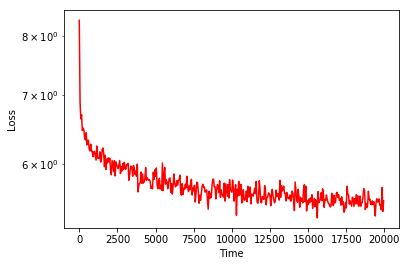

In [11]:
lr = 1e-3
n_epochs = 20000
last_epoch = -1
disp_interval = 50
batch_size = 1

loss_func = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=lr)

torch.manual_seed(1)
np.random.seed(1)

def lr_lambda(epoch):
    return 0.99**(epoch/50.0)

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda, last_epoch=last_epoch)

#model.load_state_dict(torch.load('saves/model-ernn.pt'))

Loss = []
for epoch in range(n_epochs):
    model.zero_grad()
    x_obs, y_obs = get_batch(batch_size=batch_size)
    x_obs = idx2emb(x_obs)
    y_pred, ht = model(x_obs)
    y1 = torch.argmax(y_pred.detach(),-1,keepdim=True).detach()#[:,:1,:]
    y2 = y_obs.detach()#[:,:1,:]
    y_pred = y_pred.view(-1,output_size)
    y_obs = y_obs.contiguous().view(-1)
    loss = loss_func(y_pred,y_obs)
    loss.backward()
    Loss.append(loss.tolist())
    optimizer.step()
    scheduler.step()
    if epoch % disp_interval == 0:
        print(u'Epoch{}, Loss{}\nPred:\n{}\nObs:\n{}\nRnd:\n{}\n'.format(epoch,loss.tolist(), batch2sent(y1), batch2sent(y2),poem_gen(model)))
        torch.save(model.state_dict(),'saves/model-ernn.pt')
window_size = 50
avg_losses = np.array(Loss)[:len(Loss)//50 *50].reshape([-1,window_size]).mean(1)
pl.plot(np.arange(0,len(Loss)//50 *50,window_size), avg_losses,'r-')
pl.xlabel('Time')
pl.ylabel('Loss')
pl.yscale('log')


In [171]:
word_embeddings.weight[1]

tensor([-0.1807,  0.6392,  0.1268,  1.1103, -1.6153, -0.1511, -0.0435,
        -0.0471, -0.8821, -0.4894, -0.1626,  0.1210,  1.6830, -0.1591,
        -0.0498, -0.0988,  0.3077,  1.0061,  0.2484, -0.7002])